In [4]:
import os
import math
import random
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from vqmodel import *

%load_ext autoreload
%autoreload 2

def set_seed(s=2555304):
    random.seed(s); np.random.seed(s); torch.manual_seed(s); torch.cuda.manual_seed_all(s)

def running_in_colab() -> bool:
    """Return True if we're in Google Colab."""
    try:
        import google.colab
        return True
    except Exception:
        return False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
fileList  = [
    'X1_train.pkl','X2_train.pkl','X3_train.pkl',
    'X1_test.pkl','X2_test.pkl','X3_test.pkl',
    'y_train_.pkl','y_test_.pkl'
]
varNames = [
    'X1_train','X2_train','X3_train',
    'X1_test','X2_test','X3_test',
    'y_train_','y_test_'
]

In [10]:
if running_in_colab():
  from google.colab import drive
  drive.mount('/content/drive')
  for i, fileItem in enumerate(fileList):
    fileList[i] = "/content/drive/MyDrive/" + fileItem

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
loaded = {}
for name, fname in zip(varNames, fileList):
    with open(fname, 'rb') as f:
        loaded[name] = pickle.load(f)

globals().update(loaded)

/tmp/ipython-input-2027356381.py:4: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  loaded[name] = pickle.load(f)


In [12]:
def loader_function(X, y=None, batch_size=64, shuffle=True, num_workers=4, pin_memory=True, normalize=True):
    """
    X: either a single np.ndarray or a list/tuple of arrays.
       Each array can be (N,H,W), (N,C,H,W) or (N,H,W,C).
       All arrays must share the same N,H,W. Channels are concatenated.
    y: optional labels (N,).
    """
    def to_nchw(a):
        a = np.asarray(a)
        assert a.ndim in (3,4), "Each X must be (N,H,W) or (N,C,H,W) or (N,H,W,C)"
        if a.ndim == 3:                 # (N,H,W) -> (N,1,H,W)
            a = a[:, None, :, :]
        elif a.ndim == 4:
            # heuristics: move channels-last to channels-first if needed
            if a.shape[1] not in (1,2,3) and a.shape[-1] in (1,2,3):
                a = np.transpose(a, (0,3,1,2))
        return a.astype(np.float32, copy=False)

    # Stack multiple inputs along channel dim
    if isinstance(X, (list, tuple)):
        xs = [to_nchw(a) for a in X]
        N, _, H, W = xs[0].shape
        for a in xs[1:]:
            assert a.shape[0]==N and a.shape[2]==H and a.shape[3]==W, "Mismatched N/H/W across inputs"
        Xn = np.ascontiguousarray(np.concatenate(xs, axis=1))   # (N, C_total, H, W)
    else:
        Xn = np.ascontiguousarray(to_nchw(X))                   # (N, C, H, W)

    class _DS(Dataset):
        def __init__(self, Xn, y, normalize):
            self.X = Xn
            self.y = None if y is None else np.asarray(y)
            self.normalize = normalize
        def __len__(self): return self.X.shape[0]
        def __getitem__(self, i):
            x = torch.from_numpy(self.X[i])  # (C,H,W), float32
            if self.normalize:
                m = x.mean(dim=(1,2), keepdim=True)
                s = x.std(dim=(1,2), keepdim=True, unbiased=False)
                x = (x - m) / (s + 1e-8)
                x = torch.nan_to_num(x)
            if self.y is None:
                return x
            yy = self.y[i]
            if not torch.is_tensor(yy):
                try: yy = torch.tensor(yy, dtype=torch.long)
                except Exception: pass
            return x, yy

    ds = _DS(Xn, y, normalize)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, pin_memory=pin_memory)


In [13]:
def train_vqvae(
    model, train_loader, val_loader, optimizer,
    device="cuda", epochs=100,
    beta_start=0.1, beta_end=None, warmup_epochs=2, ramp_epochs=20
):
    os.makedirs("output_images", exist_ok=True)
    model.to(device)

    if beta_end is None:
        beta_end = float(model.quantizer.beta)

    train_total, val_total = [], []
    train_recon, train_vq = [], []
    code_usage_hist, perplexity_hist = [], []

    K = getattr(model.quantizer, "num_embeddings", None)

    for epoch in range(1, epochs + 1):
        # ---------------- beta schedule + quantize gate ----------------
        if epoch <= warmup_epochs:
            beta_now = beta_start
            quantize_now = False
        elif epoch <= warmup_epochs + ramp_epochs:
            p = (epoch - warmup_epochs) / float(ramp_epochs)
            beta_now = beta_start + p * (beta_end - beta_start)
            quantize_now = True
        else:
            beta_now = beta_end
            quantize_now = True
        model.quantizer.beta = float(beta_now)

        # --------------------------- TRAIN ----------------------------
        model.train()
        total_loss_sum = 0.0
        recon_loss_sum = 0.0
        vq_loss_sum = 0.0
        n_train = 0

        counts_epoch = None if K is None else np.zeros(K, dtype=np.int64)

        for batch in train_loader:
            # unwrap (x, y) -> x, or list/tuple -> first element
            xb = batch[0] if isinstance(batch, (list, tuple)) else batch
            xb = xb.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)
            out = model(xb, quantize=quantize_now)  # expects dict with total/recon/vq/indices
            loss = out["total_loss"]
            loss.backward()
            optimizer.step()

            bs = xb.size(0)
            n_train += bs
            total_loss_sum += out["total_loss"].item() * bs
            recon_loss_sum += out["recon_loss"].item() * bs
            vq_loss_sum    += out["vq_loss"].item() * bs

            # accumulate code counts (epoch-level) for usage/perplexity
            if quantize_now and (K is not None) and ("indices" in out) and (out["indices"] is not None):
                idx = out["indices"]
                if isinstance(idx, (list, tuple)):
                    idx = torch.stack(idx)
                idx = idx.view(-1).detach().to("cpu")
                c = torch.bincount(idx, minlength=K).numpy()
                counts_epoch += c

        train_total.append(total_loss_sum / n_train)
        train_recon.append(recon_loss_sum / n_train)
        train_vq.append(vq_loss_sum / n_train)

        # ---- epoch code usage & perplexity ----
        if (counts_epoch is not None) and (counts_epoch.sum() > 0):
            code_usage = int((counts_epoch > 0).sum())
            p = counts_epoch / counts_epoch.sum()
            nz = p > 0
            H = float(-(p[nz] * np.log(p[nz])).sum())
            perplexity = float(np.exp(H))
        else:
            code_usage = 0
            perplexity = float("nan")
        code_usage_hist.append(code_usage)
        perplexity_hist.append(perplexity)

        # -------------------------- VALIDATE --------------------------
        model.eval()
        val_sum = 0.0
        n_val = 0
        with torch.no_grad():
            for batch in val_loader:
                xb = batch[0] if isinstance(batch, (list, tuple)) else batch
                xb = xb.to(device, non_blocking=True)

                out = model(xb, quantize=quantize_now)
                bs = xb.size(0)
                n_val += bs
                val_sum += out["total_loss"].item() * bs

        val_total.append(val_sum / n_val)

        print(f"[Epoch {epoch:03d}] β={beta_now:.3f} "
              f"Q={'on' if quantize_now else 'off'} | "
              f"Train {train_total[-1]:.4f} | Val {val_total[-1]:.4f} | "
              f"Recon {train_recon[-1]:.4f} | VQ {train_vq[-1]:.4f} | "
              f"Codes {code_usage_hist[-1]} | Perp {perplexity_hist[-1]:.1f}")

    # ---------------------------- PLOTS ------------------------------
    ep = range(1, epochs + 1)
    plt.figure(figsize=(14, 9))
    plt.subplot(2,3,1); plt.plot(ep, train_total, label='Train'); plt.plot(ep, val_total, label='Val'); plt.title("Total Loss"); plt.legend()
    plt.subplot(2,3,2); plt.plot(ep, train_recon, label='Recon'); plt.title("Reconstruction Loss"); plt.legend()
    plt.subplot(2,3,3); plt.plot(ep, train_vq, label='VQ'); plt.title("VQ Loss"); plt.legend()
    plt.subplot(2,3,4); plt.plot(ep, code_usage_hist, label='Unique Codes'); plt.title("Code Usage"); plt.legend()
    plt.subplot(2,3,5); plt.plot(ep, perplexity_hist, label='Perplexity'); plt.title("Codebook Perplexity"); plt.legend()
    plt.tight_layout()
    plt.savefig("output_images/Training_graphs.png")
    plt.show()

    # return {
    #     "train_total": train_total,
    #     "val_total": val_total,
    #     "train_recon": train_recon,
    #     "train_vq": train_vq,
    #     "code_usage": code_usage_hist,
    #     "perplexity": perplexity_hist,
    # }


In [14]:
TrainLoad = loader_function([X1_train, X2_train, X3_train], y_train_, num_workers=0)
TestLoad  = loader_function([X1_test,  X2_test,  X3_test],  y_test_,  num_workers=0)

In [21]:
model = VQVAE(in_channels=3, beta=0.25, embedding_dim=56, num_embeddings=256)
optimizer = torch.optim.Adam(model.parameters(), lr=0.25e-4)
device = "cuda" if torch.cuda.is_available() else "cpu"

[Epoch 001] β=0.020 Q=off | Train 12.4416 | Val 0.8868 | Recon 12.4416 | VQ 0.0000 | Codes 0 | Perp nan
[Epoch 002] β=0.020 Q=off | Train 0.7320 | Val 0.5649 | Recon 0.7320 | VQ 0.0000 | Codes 0 | Perp nan
[Epoch 003] β=0.021 Q=on | Train 1.8034 | Val 1.8661 | Recon 0.8969 | VQ 0.9065 | Codes 173 | Perp 8.7
[Epoch 004] β=0.022 Q=on | Train 2.3085 | Val 2.3693 | Recon 0.8650 | VQ 1.4435 | Codes 165 | Perp 8.2
[Epoch 005] β=0.023 Q=on | Train 2.9444 | Val 2.9530 | Recon 0.8458 | VQ 2.0986 | Codes 161 | Perp 8.3
[Epoch 006] β=0.024 Q=on | Train 3.6557 | Val 3.6619 | Recon 0.8290 | VQ 2.8267 | Codes 160 | Perp 9.1
[Epoch 007] β=0.025 Q=on | Train 4.5549 | Val 4.5070 | Recon 0.8101 | VQ 3.7448 | Codes 160 | Perp 9.9
[Epoch 008] β=0.026 Q=on | Train 5.6578 | Val 5.4937 | Recon 0.7908 | VQ 4.8669 | Codes 151 | Perp 11.0
[Epoch 009] β=0.027 Q=on | Train 6.7794 | Val 6.6259 | Recon 0.7774 | VQ 6.0020 | Codes 162 | Perp 12.4
[Epoch 010] β=0.028 Q=on | Train 8.1413 | Val 7.8818 | Recon 0.7533 | V

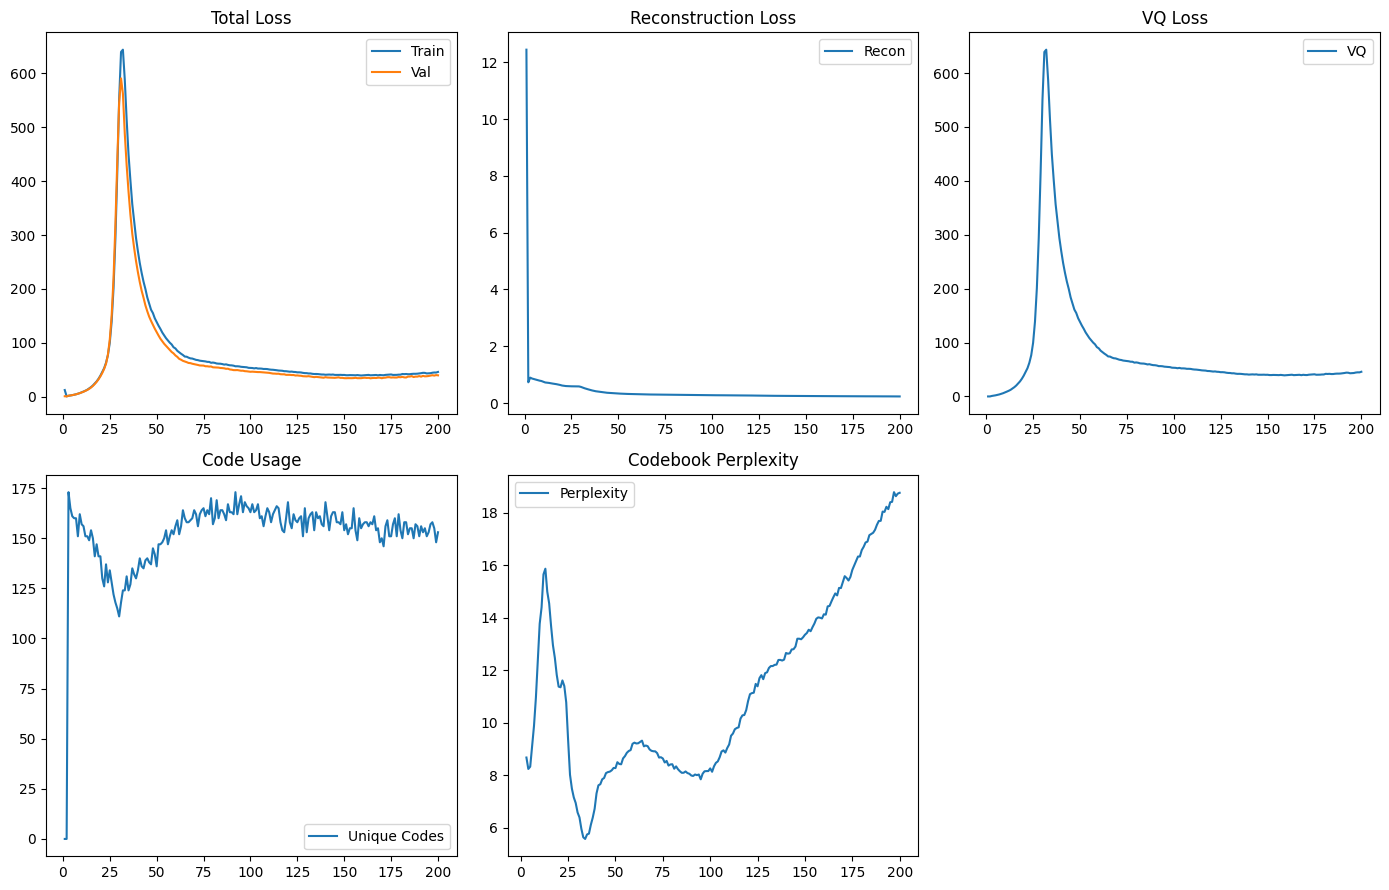

In [27]:
# train_vqvae(model, TrainLoad, TestLoad, optimizer, epochs=100)

train_vqvae(model, TrainLoad, TestLoad, optimizer,
            epochs=200, beta_start=0.02, beta_end=0.08, warmup_epochs=2, ramp_epochs=60)

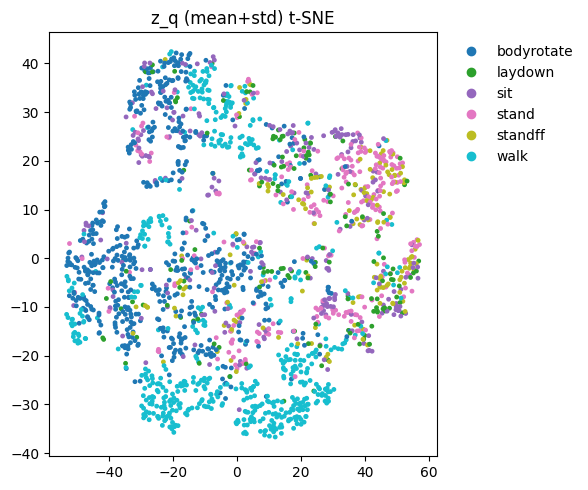

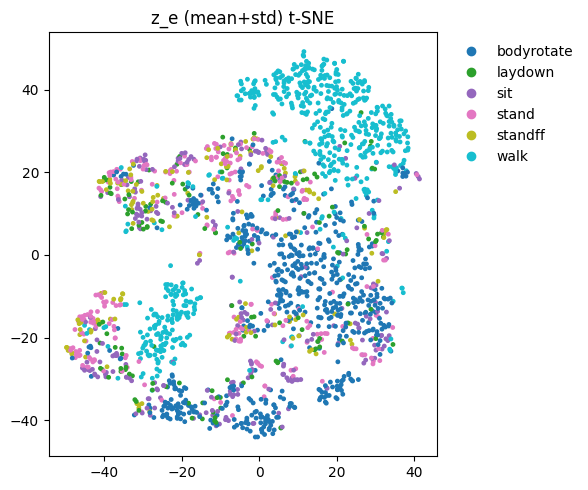

In [28]:
from sklearn.preprocessing import LabelEncoder

def get_latent_features(model, loader, device="cuda", source="zq", pool="meanstd"):
    """
    source: 'zq' (quantized) or 'ze' (pre-quantization via model.encoder)
    pool  : 'meanstd' (concat mean+std per channel), 'mean', or 'flat' (C*H*W)
    """
    model.eval()
    X, y = [], []
    with torch.no_grad():
        for batch in loader:
            xb = batch[0] if isinstance(batch, (list, tuple)) else batch
            yb = batch[1] if (isinstance(batch, (list, tuple)) and len(batch) > 1) else None
            xb = xb.to(device)

            if source == "zq":
                z = model(xb, quantize=True)["z_q"]        # [B,C,H,W]
            else:
                z = model.encoder(xb)                      # [B,C,H,W]  (z_e)

            if pool == "meanstd":
                m = z.mean((2,3)); s = z.std((2,3))
                feat = torch.cat([m, s], dim=1)           # [B, 2C]
            elif pool == "mean":
                feat = z.mean((2,3))                      # [B, C]
            else:  # 'flat' (careful with memory)
                feat = z.permute(0,2,3,1).reshape(z.size(0), -1)

            X.append(feat.cpu().numpy())
            if yb is not None:
                y.append(yb.detach().cpu().numpy() if torch.is_tensor(yb) else np.asarray(yb))

    X = np.concatenate(X, axis=0)
    y = None if not y else np.concatenate(y)
    return X, y

def plot_latent_2d(X, y=None, title="Latent space (t-SNE)"):
    # PCA -> t-SNE
    Xp = PCA(n_components=min(50, X.shape[1]-1)).fit_transform(X)
    X2 = TSNE(n_components=2, init="pca", learning_rate="auto", perplexity=30).fit_transform(Xp)

    plt.figure(figsize=(6,5))
    if y is None:
        plt.scatter(X2[:,0], X2[:,1], s=6)
    else:
        y_arr = np.asarray(y)
        # Encode non-numeric labels so matplotlib can color them
        if y_arr.dtype.kind not in "iu":
            le = LabelEncoder()
            y_plot = le.fit_transform(y_arr.astype(str))
            cmap = plt.get_cmap("tab10", len(le.classes_))
            plt.scatter(X2[:,0], X2[:,1], c=y_plot, s=6, cmap=cmap)
            # optional legend mapping colors -> class names
            handles = [plt.Line2D([], [], marker='o', linestyle='', color=cmap(i), label=cls, markersize=6)
                       for i, cls in enumerate(le.classes_)]
            plt.legend(handles=handles, bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)
        else:
            plt.scatter(X2[:,0], X2[:,1], c=y_arr, s=6, cmap="tab10")

    plt.title(title)
    plt.tight_layout()
    plt.show()
    return X2

# ---- Usage (same) ----
Xfeat, y = get_latent_features(model, TrainLoad, device=device, source="zq", pool="meanstd")
_ = plot_latent_2d(Xfeat, y, title="z_q (mean+std) t-SNE")

# For pre-quantization:
Xfeat_ze, y = get_latent_features(model, TrainLoad, device=device, source="ze", pool="meanstd")
_ = plot_latent_2d(Xfeat_ze, y, title="z_e (mean+std) t-SNE")


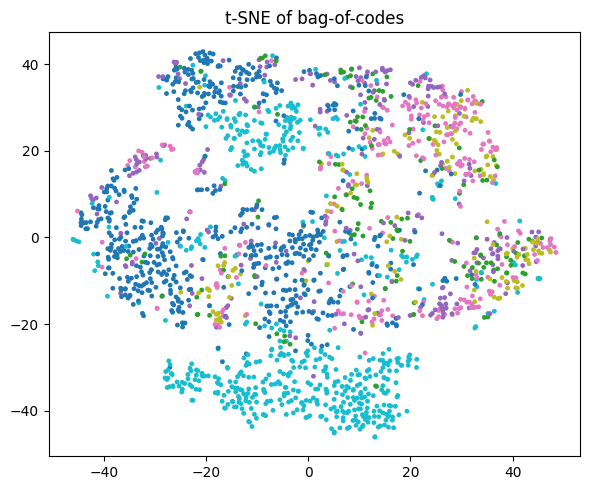

In [30]:
def bow_tsne(model, loader, device="cuda"):
    K = model.quantizer.num_embeddings
    model.eval(); X, y = [], []
    with torch.no_grad():
        for batch in loader:
            xb = batch[0] if isinstance(batch, (list, tuple)) else batch
            yb = batch[1] if (isinstance(batch, (list, tuple)) and len(batch) > 1) else None
            idx = model(xb.to(device), quantize=True)["indices"].view(xb.size(0), -1)
            for i in range(idx.size(0)):
                h = torch.bincount(idx[i], minlength=K).float()
                h = h / (h.sum() + 1e-8)      # L1
                h = torch.sqrt(h); h = h / (h.norm() + 1e-8)  # Hellinger + L2
                X.append(h.cpu().numpy())
            if yb is not None:
                y.append(yb.detach().cpu().numpy() if torch.is_tensor(yb) else np.asarray(yb))
    X = np.stack(X); y = None if not y else np.concatenate(y)

    Xp = PCA(n_components=min(50, X.shape[1]-1)).fit_transform(X)
    X2 = TSNE(n_components=2, init="pca", learning_rate="auto", perplexity=30).fit_transform(Xp)

    plt.figure(figsize=(6,5))
    if y is None:
        plt.scatter(X2[:,0], X2[:,1], s=6)
    else:
        y_arr = np.asarray(y)
        y_plot = LabelEncoder().fit_transform(y_arr.astype(str)) if y_arr.dtype.kind not in "iu" else y_arr
        plt.scatter(X2[:,0], X2[:,1], c=y_plot, s=6, cmap="tab10")
    plt.title("t-SNE of bag-of-codes"); plt.tight_layout(); plt.show()
    return X2, y


_ = bow_tsne(model, TrainLoad, device=device)